<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/Copy_of_rock_paper_scissors_mobilenet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissors (using MobileNetV2 network)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments/)

## Experiment overview

In this experiment we will build a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) model using [Tensorflow](https://www.tensorflow.org/) to recognize Rock-Paper-Scissors signs (gestures) on the photo.

Instead of training the model from scratch we will use an [MobileNetV2](https://keras.io/applications/#mobilenetv2) model which is pre-trained on the [ImageNet](http://www.image-net.org/) dataset, a large dataset of 1.4M images and 1000 classes of web images.

![rock_paper_scissors_cnn.jpg](https://github.com/trekhleb/machine-learning-experiments/blob/master/demos/src/images/rock_paper_scissors_mobilenet_v2.jpg?raw=1)

_Inspired by [Getting started with TensorFlow 2.0](https://medium.com/@himanshurawlani/getting-started-with-tensorflow-2-0-faf5428febae) article._

## Importing dependencies

In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Configuring TensorBoard

We will use TensorBoard as a helper to debug the model training process.

In [ ]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs.
!rm -rf ./logs/

## Loading the dataset

We will download Rock-Paper-Scissors dataset from [TensorFlow Datasets](https://github.com/tensorflow/datasets) collection. To do that we loaded a `tensorflow_datasets` module.

`tensorflow_datasets` defines a collection of datasets ready-to-use with TensorFlow.

Each dataset is defined as a [tfds.core.DatasetBuilder](https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder), which encapsulates the logic to download the dataset and construct an input pipeline, as well as contains the dataset documentation (version, splits, number of examples, etc.).

In [ ]:
# See available datasets
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [ ]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to tmp/rock_paper_scissors/3.0.0.incompleteCGWESG/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to tmp/rock_paper_scissors/3.0.0.incompleteCGWESG/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(list(dataset_train_raw)), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(list(dataset_test_raw)), '\n')

Raw train dataset: <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw train dataset size: 2520 

Raw test dataset: <DatasetV1Adapter shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Raw test dataset size: 372 



In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

In [ ]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [ ]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

# For Mobilenet v2 possible input sizes are [96, 128, 160, 192, 224].
INPUT_IMG_SIZE_REDUCED = 128
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 128
Input image shape (reduced): (128, 128, 3)


Input image size: 128
Input image shape: (128, 128, 3)


In [ ]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [ ]:
print(get_label_name(0));
print(get_label_name(1));
print(get_label_name(2));

rock
paper
scissors


## Exploring the dataset

In [ ]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

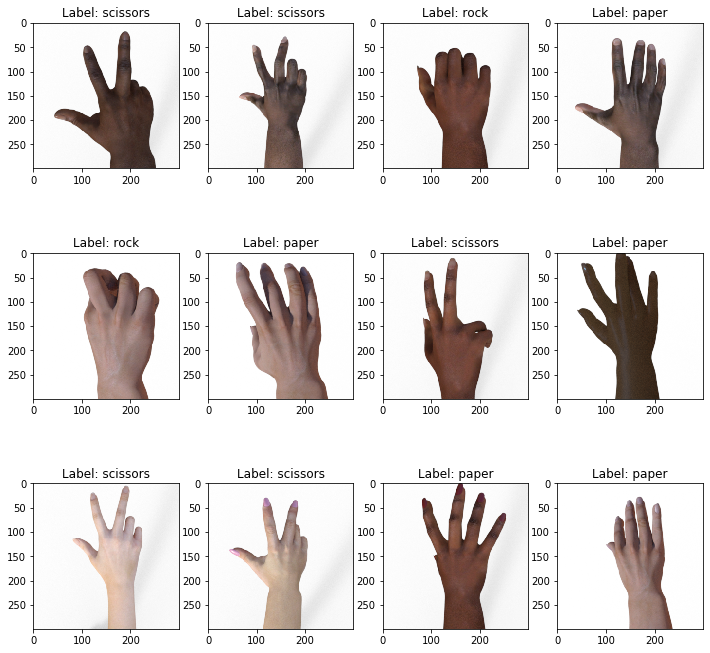

In [ ]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [ ]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Pre-processing the dataset

In [ ]:
def format_example(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [ ]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [ ]:
# Explore what values are used to represent the image. 
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (128, 128, 3) 

[[[0.99521387 0.99521387 0.99521387]
  [0.99607843 0.99607843 0.99607843]
  [0.9939281  0.9939281  0.9939281 ]
  ...
  [0.9838513  0.9838513  0.9838513 ]
  [0.9856216  0.9856216  0.9856216 ]
  [0.98129785 0.98129785 0.98129785]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9960181  0.9960181  0.9960181 ]
  [0.99601716 0.99601716 0.99601716]
  ...
  [0.9818407  0.9818407  0.9818407 ]
  [0.984375   0.984375   0.984375  ]
  [0.98169994 0.98169994 0.98169994]]

 [[0.99607843 0.99607843 0.99607843]
  [0.99607843 0.99607843 0.99607843]
  [0.9953719  0.9953719  0.9953719 ]
  ...
  [0.9859232  0.9859232  0.9859232 ]
  [0.98425245 0.98425245 0.98425245]
  [0.97992975 0.97992975 0.97992975]]

 ...

 [[0.98749423 0.98749423 0.98749423]
  [0.9882133  0.9882133  0.9882133 ]
  [0.986736   0.986736   0.986736  ]
  ...
  [0.972549   0.972549   0.972549  ]
  [0.97391427 0.97391427 0.97391427]
  [0.9755237  0.9755237  0.9755237 ]]

 [[0.9907878  0.9907878  0.9907878

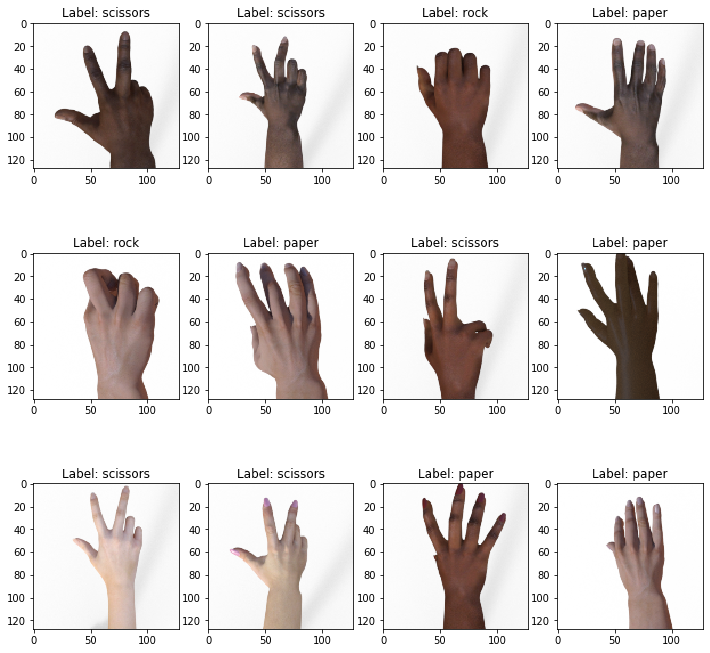

In [ ]:
# Explore preprocessed training dataset images.
preview_dataset(dataset_train)

## Data augmentation

One of the way to fight the [model overfitting](https://en.wikipedia.org/wiki/Overfitting) and to generalize the model to a broader set of examples is to augment the training data.

As you saw from the previous section all training examples have a white background and vertically positioned right hands. But what if the image with the hand will be horizontally positioned or what if the background will not be that bright. What if instead of a right hand the model will see a left hand. To make our model a little bit more universal we're going to flip and rotate images and also to adjust background colors.   

You may read more about a [Simple and efficient data augmentations using the Tensorfow tf.Data and Dataset API](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/).

In [ ]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [ ]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [ ]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [ ]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [ ]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [ ]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [ ]:
dataset_train_augmented = dataset_train.map(augment_data)

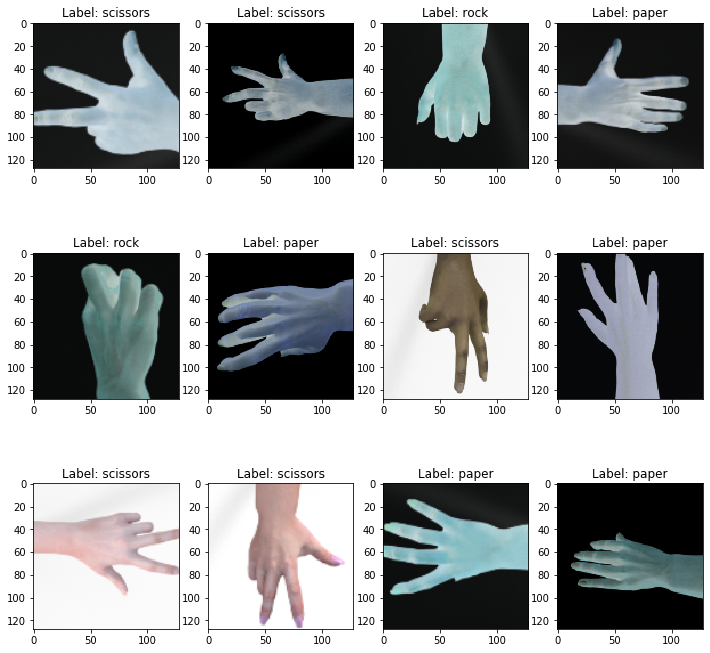

In [ ]:
# Explore augmented training dataset.
preview_dataset(dataset_train_augmented)

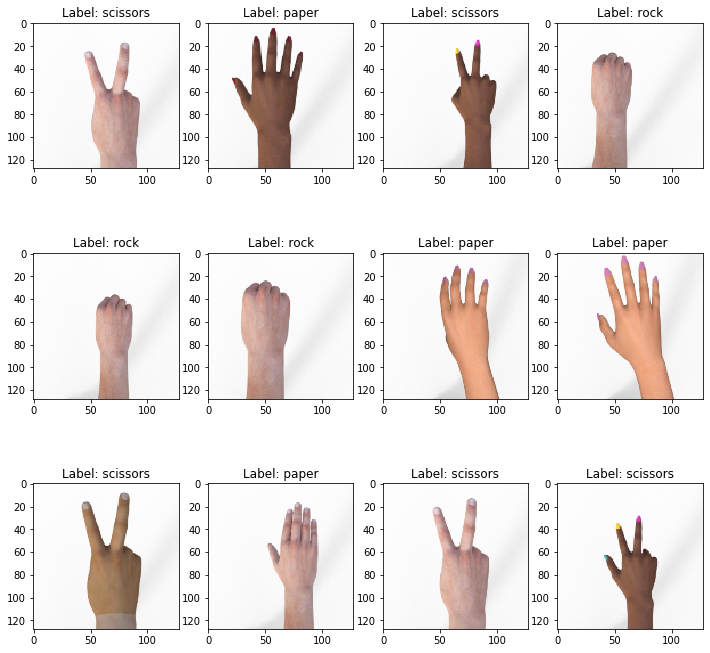

In [ ]:
# Explore test dataset.
preview_dataset(dataset_test)

## Data shuffling and batching

We don't want our model to learn anything from the order or grouping of the images in the dataset. To avoid that we will shuffle the training examples. Also we're going to split the training set by batches to speed up training process and make it less memory consuming.

In [ ]:
BATCH_SIZE = 800

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [ ]:
print(dataset_train_augmented_shuffled)
print(dataset_test_shuffled)

<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>
<DatasetV1Adapter shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int64)>


Label batch shape: (800,) 

Image batch shape: (800, 128, 128, 3) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0 2 2 2 0 1
 2 1 0 0 0 0 0 1 1 2 2 0 0 2 1 1 0 0 1 2 1 0 0 0 0 1 2 1 1 2 2 1 1 1 1 1 2
 0 0 2 1 0 1 0 0 1 1 1 1 2 1 1 0 0 2 2 1 0 0 1 1 2 1 1 0 0 0 2 0 0 1 1 2 0
 2 0 1 1 1 2 0 1 0 1 2 1 0 1 2 2 0 2 1 0 0 1 0 1 0 1 2 1 2 2 1 0 2 0 1 1 2
 0 2 2 1 0 1 2 2 1 1 0 2 0 0 1 1 0 1 2 2 0 0 2 1 1 0 1 2 0 1 1 1 2 0 2 1 2
 1 1 1 2 2 2 1 0 2 0 1 0 1 2 0 0 2 0 1 1 0 2 2 2 1 1 1 0 1 0 2 0 0 1 1 1 2
 1 2 1 2 2 0 2 1 0 1 0 0 2 1 1 0 2 2 2 0 1 1 1 2 0 1 0 2 1 1 2 1 2 2 0 1 2
 2 0 2 1 0 2 0 0 1 0 2 2 0 0 2 2 0 0 2 2 1 0 0 0 2 1 1 0 2 0 1 1 1 2 1 1 0
 1 1 2 2 2 1 2 0 0 0 2 0 2 0 0 0 0 2 2 0 1 0 0 1 1 0 1 1 0 2 1 0 2 0 1 1 0
 2 1 0 0 1 2 2 0 1 1 2 2 2 0 2 2 2 0 2 1 2 0 2 1 0 1 1 1 0 2 0 1 0 1 0 0 0
 0 1 2 1 0 2 2 0 2 2 2 1 2 1 2 0 1 0 0 0 1 1 1 1 1 2 1 1 1 0 1 0 2 0 0 1 0
 0 2 0 0 1 1 1 1 2 2 2 1 1 0 1 2 0 1 2 0 0 1 1 0 2 2 1 2 2 1 1 0 2 1 2 2 0
 1 0 0 1 2 0 2 1 1 

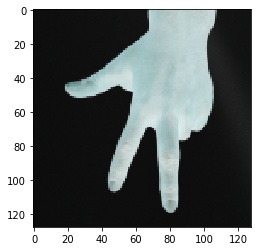

In [ ]:
# Debugging the batches using conversion to Numpy arrays.
batches = tfds.as_numpy(dataset_train_augmented_shuffled)
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

## Creating the model

### Loading MobileNetV2 model

We don't want to use the top classification layer of the pre-trained MobileNetV2 model as it contains 1000 classes when we need only 3 (`rock`, `paper` and `scissors`). We will specify that by setting a `include_top` parameter to `False`.

You may read more about `MobileV2` application on [MobileV2 Keras Documentation](https://keras.io/applications/#mobilenetv2)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
# Freezing the base model since we don't want to re-train it.
# We're only interesting in its feature extraction.
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes=True,
    show_layer_names=True,
)

### Adding a classification head

In [ ]:
model = tf.keras.models.Sequential()

model.add(base_model)

# model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


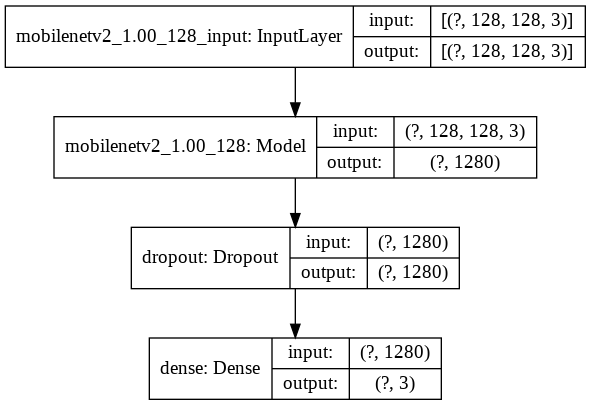

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Compiling the model

In [ ]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

## Training the model

In [ ]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE if NUM_TEST_EXAMPLES // BATCH_SIZE else 1

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 3
validation_steps: 1


In [ ]:
!rm -rf tmp/checkpoints
!rm -rf logs

In [ ]:
# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [ ]:
initial_epochs = 20

In [ ]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Train for 3 steps, validate for 1 steps
Epoch 1/20
3/3 [==============================] - 27s 9s/step - loss: 1.7625 - accuracy: 0.3379 - val_loss: 1.4945 - val_accuracy: 0.2634
Epoch 2/20
3/3 [==============================] - 11s 4s/step - loss: 1.4305 - accuracy: 0.4419 - val_loss: 1.2347 - val_accuracy: 0.4113
Epoch 3/20
3/3 [==============================] - 10s 3s/step - loss: 1.2506 - accuracy: 0.4744 - val_loss: 1.0589 - val_accuracy: 0.4731
Epoch 4/20
3/3 [==============================] - 12s 4s/step - loss: 1.1228 - accuracy: 0.5273 - val_loss: 1.2867 - val_accuracy: 0.4758
Epoch 5/20
3/3 [==============================] - 9s 3s/step - loss: 1.0505 - accuracy: 0.5638 - val_loss: 1.0671 - val_accuracy: 0.5887
Epoch 6/20
3/3 [==============================] - 14s 5s/step - loss: 0.9376 - accuracy: 0.6331 - val_loss: 1.0062 - val_accuracy: 0.6344
Epoch 7/20
3/3 [==============================] - 8s 3s/step - loss: 0.8732 - accuracy: 0.6564 - val_loss: 0.8927 - val_accuracy: 0.6

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

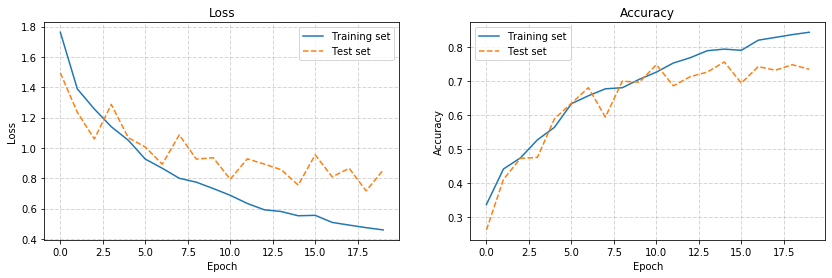

In [ ]:
render_training_history(training_history)

## Model fine tuning

We may try to unfreeze some of the top layers of the `base_model` and to train it a little bit more so to adjust top layers to our Rock-Paper-Scissors dataset. 

In [ ]:
# Un-freeze the top layers of the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  156


In [ ]:
# Fine tune from this layer onwards.
fine_tune_at = 149

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer = rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [ ]:
# The number of additional epochs during which we're going to fine tune the model.
fine_tuning_epochs = 10

In [ ]:
training_history_fine = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=initial_epochs + fine_tuning_epochs,
    initial_epoch=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[tensorboard_callback],
    verbose=1
)

Train for 3 steps, validate for 1 steps
Epoch 21/30
3/3 [==============================] - 28s 9s/step - loss: 0.3986 - accuracy: 0.8671 - val_loss: 0.9486 - val_accuracy: 0.7419
Epoch 22/30
3/3 [==============================] - 4s 1s/step - loss: 0.2943 - accuracy: 0.9151 - val_loss: 0.9152 - val_accuracy: 0.7500
Epoch 23/30
3/3 [==============================] - 11s 4s/step - loss: 0.2693 - accuracy: 0.9262 - val_loss: 0.8829 - val_accuracy: 0.7554
Epoch 24/30
3/3 [==============================] - 11s 4s/step - loss: 0.2251 - accuracy: 0.9459 - val_loss: 0.8645 - val_accuracy: 0.7581
Epoch 25/30
3/3 [==============================] - 14s 5s/step - loss: 0.2084 - accuracy: 0.9521 - val_loss: 0.8264 - val_accuracy: 0.7823
Epoch 26/30
3/3 [==============================] - 9s 3s/step - loss: 0.2193 - accuracy: 0.9570 - val_loss: 0.8203 - val_accuracy: 0.7930
Epoch 27/30
3/3 [==============================] - 10s 3s/step - loss: 0.1837 - accuracy: 0.9552 - val_loss: 0.8219 - val_accura

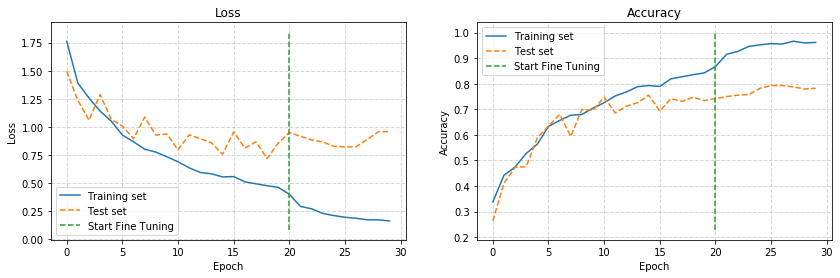

In [ ]:
loss = training_history.history['loss'] + training_history_fine.history['loss']
val_loss = training_history.history['val_loss'] + training_history_fine.history['val_loss']

accuracy = training_history.history['accuracy'] + training_history_fine.history['accuracy']
val_accuracy = training_history.history['val_accuracy'] + training_history_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## Debugging the training with TensorBoard

In [ ]:
%tensorboard --logdir logs/fit

## Evaluating model accuracy

In [ ]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

      1/Unknown - 1s 1s/step - loss: 0.9578 - accuracy: 0.7823

In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.5349061712622643
Training accuracy:  0.8218254


Test loss:  0.9577915668487549
Test accuracy:  0.7822581


## Saving the model

In [ ]:
model_name = 'rock_paper_scissors_mobilenet_v2.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/rock_paper_scissors_mobilenet_v2/rock_paper_scissors_mobilenet_v2.h5 \
  ./demos/public/models/rock_paper_scissors_mobilenet_v2
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.